<div class="alert alert-block alert-info">
<b> Party playlist generator
</div>

Given a list of songs, we want to arrange them into a playlist that flows through a certain criteria.

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv("data/data_cleaned.csv")

In [42]:
df.columns

Index(['track_name', 'track_artist', 'track_popularity', 'track_album_name',
       'track_album_release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms'],
      dtype='object')

We want to use 'danceability' and 'energy' to create a party playlist. 

In [43]:
df[['danceability', 'energy']].describe()

,danceability,energy
count,28356.000000,28356.000000
mean,0.653372,0.698388
std,0.145785,0.183503
min,0.000000,0.000175
25%,0.561000,0.579000
50%,0.670000,0.722000
75%,0.760000,0.843000
max,0.983000,1.000000


For this create a new variable "party_score" by projection onto a line (other options possible - e.g. project onto circle to emphasize one of the features etc):

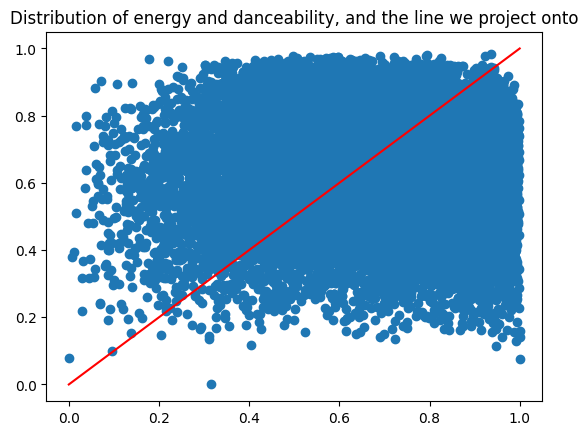

In [44]:
plt.scatter(df.energy,df.danceability)
plt.plot((0,1),(0,1),c = "red")
plt.title("Distribution of energy and danceability, and the line we project onto")
plt.show()

In [59]:
# take two-dimensional variable (x,y)

x = df.energy
y = df.danceability

# project onto line x=y

x_p = (x + y) / 2
y_p = (x + y) / 2

# take length of the vector (x_p,y_p) as new variable

z = pd.DataFrame(np.sqrt(x_p**2 + y_p**2))

# and normalize 

from sklearn.preprocessing import MinMaxScaler
party_scaler = MinMaxScaler()
df["party_score"] = party_scaler.fit_transform(z)

<AxesSubplot:ylabel='Count'>

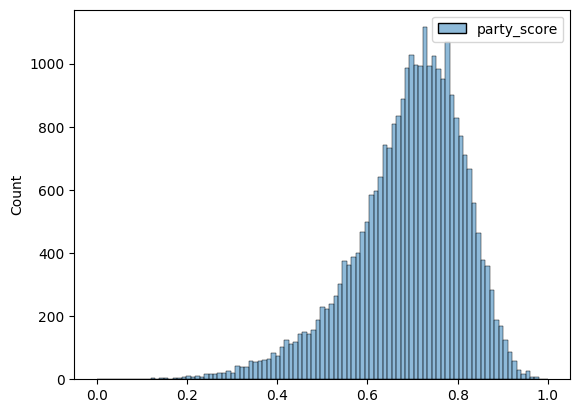

In [46]:
sns.histplot(df[["party_score"]])

Given a (random) list of $n=50$ songs, let's arrange a playlist:

In [47]:
n = 50
track_list = df[["party_score"]].sample(n)

In [48]:
#extract two minima (will be start and end song) and remove from track list

min1_idx = track_list.idxmin()
start_song = track_list[track_list.index == min1_idx[0]]
track_list.drop(index = min1_idx[0], inplace=True)

min2_idx = track_list.idxmin()
end_song = track_list[track_list.index == min2_idx[0]]
track_list.drop(index = min2_idx[0], inplace=True)

Now we have a list of songs with a "party_score" between 0 and 1 that we want to arrange on a chosen curve (__here we choose a sinus curve__). 

Idea: Create bins and fill these iteratively. If we can't find a suitable entry in the list, we use a KNN algorithm to find a filler song.

How many bins? This is determined by a pre-defined step_size, i.e. how many songs should fill the gap between a calm one (party_score low) and a dancefloor cracker (party_score high).

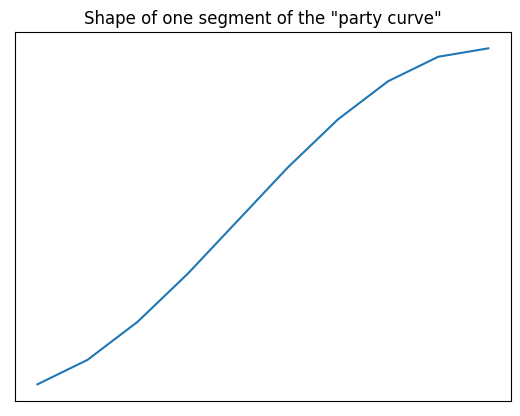

In [49]:
# define step size

b = 10

# create bins

dividers = [np.array([x*np.pi/b,(x+1)*np.pi/b]) for x in range(b)]
bins = [(np.sin(x-np.pi/2)+1)/2 for x in dividers]

plt.plot([  bins[i][1] for i in range(b) ])
plt.title('Shape of one segment of the "party curve"')
plt.xticks([])
plt.yticks([])
plt.show()

In [169]:
# fill bins with songs according to their party_score 

binned_songs = []
for bin in bins:
    in_this_bin = []
    for i,x in zip(track_list.index,track_list.party_score):
        if bin[0] < x and x <= bin[1]:
            in_this_bin.append(i)
    binned_songs.append(in_this_bin)

How often do we need to loop through binned_songs in order to put every song on the playlist?

To answer this find size of the fullest bin:

In [170]:
l = max([len(i) for i in binned_songs])

Now create a playlist by successively adding songs from binned_songs until all bins are empty, adding filler songs if necessary. 

In [171]:
from find_filler import find_fillers

used_fillers = set() # keep track of fillers
playlist = [start_song.index[0]] # initialise playlist with start_song

for iteration in range(l):
    for elt in binned_songs:
        if not elt: # case no song in bin, fill with song that is close to previous one
            filler_df = find_filler(playlist[-1])
            z = pd.DataFrame(np.sqrt(2)*(filler_df.energy + filler_df.danceability) / 2)
            filler_df["party_score"] = party_scaler.transform(z)
            
            # exclude already used filler songs
            available_fillers = filler_df[~filler_df.index.isin(used_fillers)]

            if not available_fillers.empty:
                # find the song with party_score closest to previous one
                prev_party_score = df.loc[playlist[-1], "party_score"]
                closest_index = available_fillers.party_score.sub(prev_party_score).abs().idxmin()

                # add to playlist and mark as used
                playlist.append(closest_index)
                used_fillers.add(closest_index)
            else:
                # no valid filler found
                print(f"No valid unique filler found.")
        else:
            playlist.append(elt[0])
            elt.remove(elt[0])

playlist.append(end_song.index[0]) # add end_song            

/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without f

No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.
No valid unique filler found.


/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


Look at playlist and its behaviour:

In [177]:
playlist_df = df.loc[playlist]

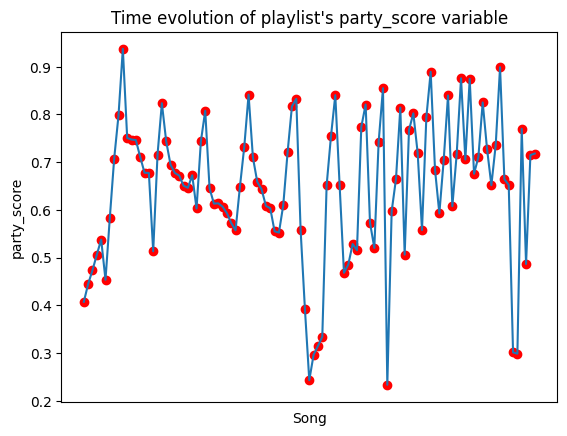

In [176]:
playlist_scores = list(playlist_df.party_score)
plt.plot(playlist_scores)
plt.scatter(range(len(playlist_scores)),playlist_scores,c="red")
plt.xticks([])
plt.xlabel("Song")
plt.ylabel("party_score")
plt.title("Time evolution of playlist's party_score variable")
plt.show()

Of course, other shapes are also possible (could also bin songs in the descending part of sin-curve etc...)